In [ ]:
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import

#check if there is an evirronment variable called ROOT_PATH
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

# import local_settings
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, OneOverSqr
from dsp_utils import seg_time
from siggen_utils import herzfeld_block
from plt_utils import plot_by_key,plot_segments

from dsp_utils import parse_samples
from autoreg_utils import clnn_kalman_matrix_prep

from runners import Runner
# from custom_optimizers import ElementWiseDecay, GlobalPNormDecay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

TfN1 = 100
TfA = 400
TfN2 = 300

TsN=60
TsA=120
TsB=20
TsC=20

# T=300
TaN=150
TaB=120

# playlist_ab = {
# 'AB0':[(P0, TaN),(Pminus, TaB)],
# 'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
# 'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
# 'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
#      }

playlist = {
# 'frogs': [(P0,TfN1),((P0,Pplus),TfA),(P0,TfN2)],
# 'anti_frogs': [(P0,TfN1),(Pplus,TfA),(P0,TfN2)],
# 'savings': 2 * [(P0, TsA), (Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
# 'savings': [(P0, TsA), (Pplus, TsA),(P0, 2000),(Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
# 'savings': 2 * [(P0, TsN), (Pplus, TsA), (Pminus, TsB), (Pchannel, TsC)],
'sprecovery': [(P0, 50),
               (Pplus, 125),
               (Pminus, 15),
               (Pchannel, 140)],
# 'evrecovery': [(P0, 50),
#                (Pplus, 120),
#                (Pminus, 15),
#                (Pchannel, 2),
#                (Pplus, 2),
#                (Pchannel, 140)],
# 'spOVRrecovery': [(P0, 50),
#                (Pplus, 450),
#                (Pminus, 15),
#                (Pchannel, 140)],
# 'spOVRrecovery_ref': [(P0, 50),
#                (Pplus, 150),
#                (Pminus, 15),
#                (Pchannel, 140)],
# 'lng_recovery': [(P0, 192),
#                (Pplus, 384),
#                (Pminus, 384),
#                (Pchannel, 400)],    
# 'ANB0':[(P0, TaN),(Pminus, TaB)],
# 'ANB1':[(P0, TaN),(Pplus,13),(P0, TaB),(Pminus, TaB)],
# 'ANB2':[(P0, TaN),(Pplus,41),(P0, TaB),(Pminus, TaB)],
# 'ANB3':[(P0, TaN),(Pplus,112),(P0, TaB),(Pminus, TaB)],
    }

# playlist.update(playlist_ab)

# def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
#     out_dict = {}
#     for z in z_list:
#         scenario_name =  f'herzfeld,z={z}'
#         pert_per_z = []
#         for n in range(n_blocks):
#             hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
#             pert_per_z.append((hz,len(hz)))
#         out_dict.update({scenario_name:pert_per_z})
#     return out_dict

# hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
# playlist.update(generate_herzfeld_scenarios(**hrz_params))
        

In [33]:
# frog_playlist = {
# f'frogs{f}': [(P0,TfN1),((P0,Pplus),TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])}

# frog_playlist_a = {
# f'anti_frogs{f}': [(P0,TfN1),(Pplus,TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])} 

# frog_playlist.update(frog_playlist_a)

In [34]:
from dsp_utils import parse_samples

In [35]:
stimulus_np = parse_samples(playlist['sprecovery'])

In [36]:
test_vec= np.stack([np.zeros(200),
                    np.zeros(200),
                    np.zeros(200),
                   np.linspace(2*Pminus,2*Pplus,200)]).T

x_test = test_vec[:,-1]
x_grid =  np.stack([np.zeros(10),
                    np.zeros(10),
                    np.zeros(10),
                   np.linspace(1.2*Pminus,1.2*Pplus,10)]).T

In [ ]:
cnt =0

results = {}
swarg1s = [
    {'noi_x': 0.0, 'noi_u': 0.0, 'noi_y': 0.0, 'noi_post_u': 0.0},
    {'noi_x': 0.1, 'noi_u': 0.0, 'noi_y': 0.0, 'noi_post_u': 0.0},
    {'noi_x': 0.0, 'noi_u': 0.1, 'noi_y': 0.0, 'noi_post_u': 0.0},
    {'noi_x': 0.0, 'noi_u': 0.0, 'noi_y': 0.1, 'noi_post_u': 0.0},
    {'noi_x': 0.0, 'noi_u': 0.0, 'noi_y': 0.0, 'noi_post_u': 0.1},
]
swarg2s =  [1e-4] #[0.05,0.1,0.2,0.5,1,2]
for i1, swarg1 in enumerate(swarg1s):
    for i2, swarg2 in enumerate(swarg2s):
        lr = swarg2
        b_high = 0.2
        noise_spec = swarg1
        beta = None
        model_construct_args =  dict(n_inputs = 4,
                          n_hidden = 2*512,
                          n_outs = 1,
                          en_bias = False,
                         b_high=b_high, first_layer_init='uniform_unity',
                        first_layer_weights_trainable = False,
                        out_layer_init='zeros',
                        post_activation_bias = None,
                        post_activation_bias_scale = 0,
                          nl = 'relu', skip_gain= 0)
        setting = {'criterion':'MSE', 'k':[0,0,0,1], 'learning_rate':lr, 'sigma_noi':0.0, 'tau_u':1,'enable_combo':True, 'noise_spec':noise_spec,
        'take_lin_measurements': i1==0, 'lin_measurement_opts': {'x_grid': x_grid}}
        runner = Runner(model_construct_args=model_construct_args,
                        test_vec=test_vec,
                        **setting)
        results[(i1,i2)] = runner.run_multiple(playlist)
        if i1 == 0:
            stepwise_lin_data = runner._stepwise_recorder.copy()
            initial_lin_data = runner._initial_recordings.copy()

running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery


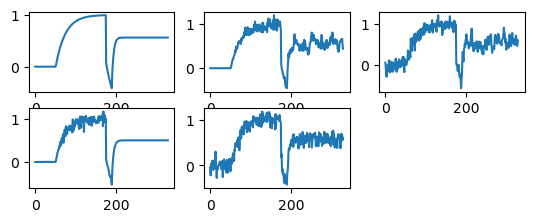

In [38]:
for i, _ in enumerate(swarg1s):
    these_results = results[i,0]
    plt.subplot(4, 3, i+1)
    plt.plot(these_results['sprecovery'].u_lp)

In [39]:
def list_of_dicts_to_dict_of_lists(list_of_dicts):
    out_dict = {}
    for d in list_of_dicts:
        for k,v in d.items():
            if k not in out_dict:
                out_dict[k] = []
            out_dict[k].append(v)
    return out_dict

In [40]:
per_step_data = list_of_dicts_to_dict_of_lists(stepwise_lin_data)

In [41]:
per_step_data.keys()

dict_keys(['e', 'u', 'y', 'x', 'Jx'])

In [42]:
for kk in ['x', 'Jx']:
    per_step_data[kk]  = [foo.squeeze()[-1] if  isinstance(foo,np.ndarray) else foo for foo in per_step_data[kk]]


In [43]:
initial_lin_data['K'].shape, initial_lin_data['H'].shape

((10, 10), (10, 10, 4))

In [44]:
per_episode_data = initial_lin_data.copy()
per_episode_data['H'] = per_episode_data['H'][:,:,-1]

In [45]:
per_episode_data['alpha'] = 2*lr

In [46]:
per_episode_data['K'].shape, per_episode_data['H'].shape

((10, 10), (10, 10))

In [47]:
opts = {'compute_lambda': True, 'x_grid': x_grid[:,-1]}

In [48]:
ref_noise_cond_id = 0
noise_cond_id = 2

duu = np.array(results[noise_cond_id,0]['sprecovery'].u_lp) - np.array(results[ref_noise_cond_id,0]['sprecovery'].u_lp)

s = this_noise_spec = swarg1s[noise_cond_id]
_p = per_episode_data

In [50]:
per_step_data['trial_type'] = [np.logical_not(np.isnan(foo)) for foo in stimulus_np]

In [52]:
per_step_data['bbar_e'] = per_step_data.pop('e')



In [53]:
# per_step_data = {k: v[1:] for k, v in per_step_data.items()}

In [54]:
per_step_data.keys()

dict_keys(['u', 'y', 'x', 'Jx', 'trial_type', 'bbar_e'])

In [61]:
from stat_utils import run_trial

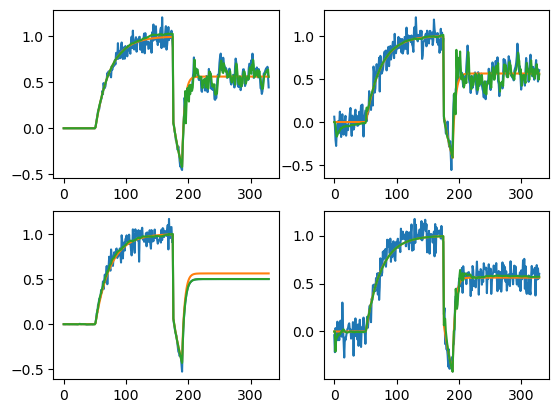

In [89]:


ref_noise_cond_id = 0
oos = []
duus =[]
for cc, noise_cond_id in enumerate(range(1, len(swarg1s))):
  

  duu = np.array(results[noise_cond_id,0]['sprecovery'].u_lp) - np.array(results[ref_noise_cond_id,0]['sprecovery'].u_lp)

  s = this_noise_spec = swarg1s[noise_cond_id]
  _p = per_episode_data
  epsilon = 1e-6
  _p['sigma_u'], _p['sigma_y'], _p['sigma_x'], _p['sigma_a'] = s['noi_u']+epsilon, s['noi_y']+epsilon, s['noi_x']+epsilon, s['noi_post_u']+epsilon


  kalman_params = clnn_kalman_matrix_prep( {'fixed': per_episode_data,
                                          'time_varying': per_step_data},
                                        timestep=None,
                                        opts=opts)
  oo = run_trial(kalman_params,
                  sim_data=duu.reshape(1,-1), #convention in kalman filter that observation and states are column vectors
                  sim_params=None, 
                  Tmax=len(stimulus_np), 
                  discard_1st_step_stats=True)
  oos.append(oo.copy())
  duus.append(duu.copy())
  plt.subplot(2, 2, cc+1)
  plt.plot(results[noise_cond_id,0]['sprecovery'].u_lp)
  plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp)
  plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp+oo['z_pred'][0,:])
# plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp+oo['][0,:])

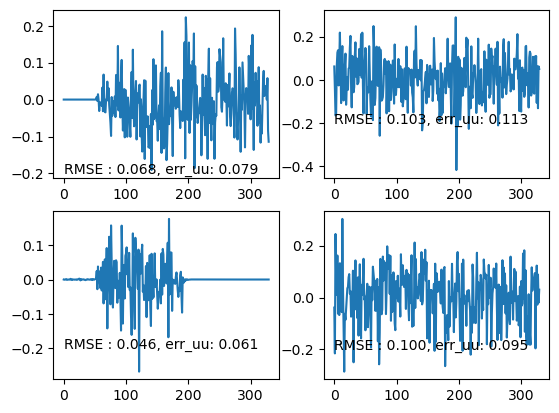

In [94]:
for cc, oo in enumerate(oos):
    plt.subplot(2, 2, cc+1)
    err_kalman = duus[cc]  - oo['z_pred'][0,:]
     
    plt.plot(err_kalman)
    plt.text(0, -0.20, f"RMSE : {np.sqrt(np.mean(err_kalman**2)):.3f}, err_uu: {np.sqrt(np.mean(duus[cc]**2)):.3f}")

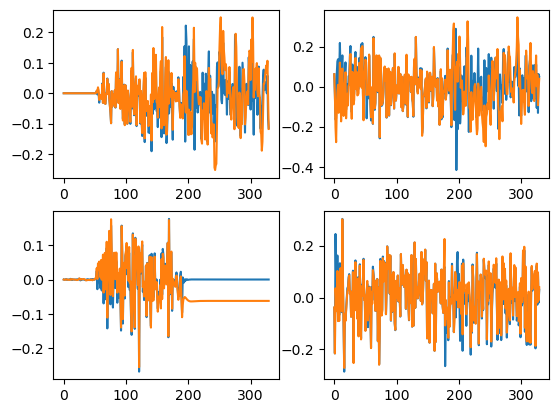

In [93]:
for cc, oo in enumerate(oos):
    plt.subplot(2, 2, cc+1)
    err_kalman = duus[cc] - oo['z_pred'][0,:]
     
    plt.plot(err_kalman)
    plt.plot(duus[cc])
    # plt.text(0, -0.20, f"RMSE : {np.sqrt(np.mean(err_kalman**2)):.3f}, err_uu: {np.sqrt(np.mean(duus[cc]**2)):.3f}")

In [66]:
np.mean(oo['lls']), np.mean(oo['lls'][1:])

(-2887248.507538198, 0.8545563652321291)

In [79]:
oo.keys()

dict_keys(['state_rms', 'obs_rms', 'avg_ll', 'lls', 's_est', 'z_obs', 'z_pred'])

In [68]:
duu

array([ 6.17360398e-02, -4.05572094e-02, -2.04083353e-01, -2.77318001e-01,
       -1.07666850e-01, -2.75843665e-02,  8.52476247e-03, -1.30943209e-01,
       -3.25125307e-02,  1.19978338e-01,  1.25640957e-02, -1.73631862e-01,
        3.38076726e-02,  8.99966508e-02, -4.36462741e-03, -1.46341205e-01,
       -7.32976105e-03,  9.81379859e-03,  7.15773702e-02, -1.58284694e-01,
       -8.40568170e-02, -3.57520543e-02, -9.40528437e-02,  2.35092756e-03,
        9.72163770e-03,  1.03503987e-01,  1.62938327e-01, -4.72279899e-02,
       -1.60658583e-01,  7.34909847e-02,  4.46811840e-02, -8.86558294e-02,
       -6.61329404e-02,  8.20088536e-02,  1.42857447e-01, -1.19395601e-02,
        7.35399872e-02, -4.38272320e-02, -4.12814952e-02, -3.32529545e-02,
        1.18339889e-01,  2.67678616e-03,  7.90836439e-02,  1.91930160e-01,
       -5.49420156e-03,  2.02078938e-01, -3.90729606e-02, -1.67990252e-01,
        2.91825943e-02,  8.06853175e-02,  1.34374604e-01,  1.22855986e-01,
       -4.23817504e-02,  